In [23]:
# Keep this cell while WIP
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## A tutorial on ShrinkTM

This is our first example getting started with transport maps. It shows how to
fit a transport map to a univariate spatial field, evaluate the fit, and generate
new samples emulating the training data. This is a simple demonstration of the
method published in [2] and [1] on a small dataset.

The notebook is separated into the following parts:

- Data loading and visualization
- Data preprocessing
- Fitting a legacy transport map with default optimization settings
- Fitting a shrinkage transport map with default optimization settings
- Evaluating the fit (scoring)
- Sampling new data
- Climate model application

References

[1] Katzfuss and Schäfer (2023, JASA). https://doi.org/10.1080/01621459.2023.2197158

[2] Chakraborty and Katzfuss (2024, preprint). https://arxiv.org/pdf/2409.19208

In [24]:
# Packages for data loading
import pathlib
import pickle

# Packages for working with array data and tensors
import numpy as np
import matplotlib.pyplot as plt
import torch

# Packages for building transport maps
from veccs import orderings
from batram.legmods import Data, SimpleTM
from batram.shrinkmods import EstimableShrinkTM


In [25]:
# after the imports set a seed for reproducibility
# anyhow, the results will be different on different machines
# cf. https://pytorch.org/docs/stable/notes/randomness.html
np.random.seed(0)
torch.manual_seed(0)


### Data Loading and Inspection

Our model assumes we are loading datasets of the following structure:
- An $N \times d$ array of spatial locations indexing the dataset
- An $n \times N$ array of observations at the $N$ indexed locations

Below we load a test dataset. The data consist of 300 replications of a
spatial field on a 30 x 30 grid over the unit square; i.e., there are $n=300$
samples of a process defined on $(0, 1)^2$ with 30 evenly spaced points in each
dimension.

In [26]:
# Load data and print dimensions

with open("../tests/data/LR900ExpLST30SIGSQT10.pkl", "rb") as f:
    data = pickle.load(f)

locs = data["locs"]
gp = data["gp"]
obs = data["data"]

print(f"Locations array dimension: {locs.shape}")
print(f"Observations array dimension: {obs.shape}")


Locations array dimension: (900, 2)
Observations array dimension: torch.Size([300, 900])


To get an idea of what the data look like, we plot the first 50 spatial fields.

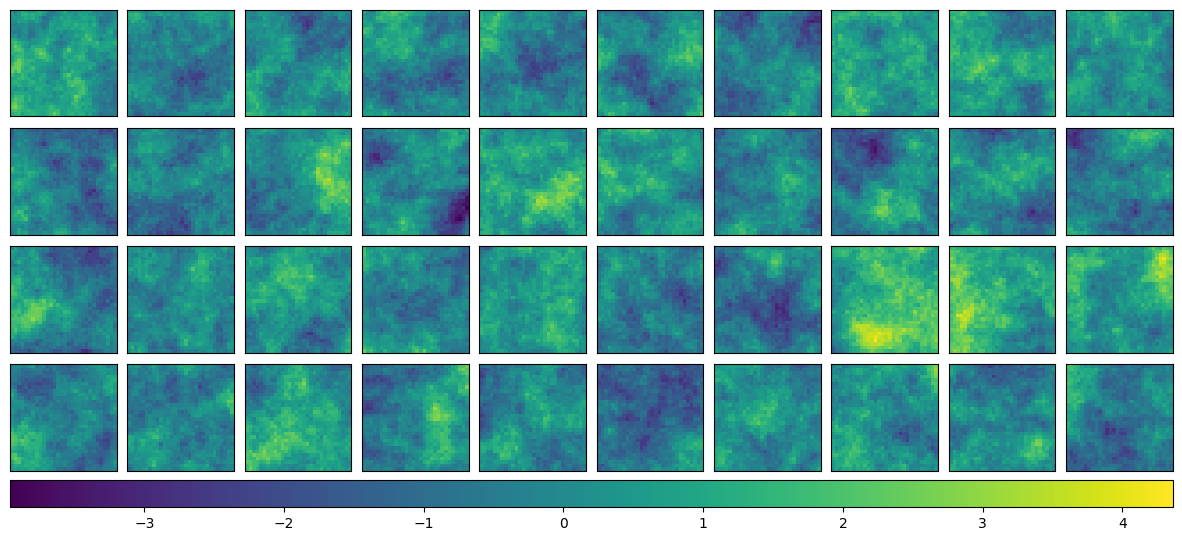

In [27]:
gspec = {"wspace": 0.1, "hspace": 0.1}
fig, ax = plt.subplots(4, 10, figsize=(15, 6), gridspec_kw=gspec, squeeze=True)
vmin, vmax = obs[:40].min(), obs[:40].max()
for i in range(40):
    _ = ax[i // 10, i % 10]
    im = _.imshow(obs[i].reshape(30, 30), vmin=vmin, vmax=vmax)
    _.set_xticks([])
    _.set_yticks([])
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.125, 0.05, 0.775, 0.045])
fig.colorbar(im, cax=cbar, orientation="horizontal")
plt.show()

### Data Preprocessing and Map Initialization

Our models assume the data have been pixel-wise centered and an ordering of the
data has been computed. We also require nearest neighbor information to fit the
model. The centering is easy to do using numpy or pytorch arrays, and the `veccs`
package provides the required functionality for the remaining steps. The next
code block demonstrates the typical preprocessing steps, then stores the
transformed data in a `Data` container.

In [28]:
#We snip first n=1 samples for training and the rest for testing.
#Please change it to your desired value.
n = 1

# Maximin ordering of the locations using the `veccs` package.
# Note, the locations array is reordered over its first dimension, whereas the
# observations are reordered over the last dimension.
order = orderings.maxmin_cpp(locs)
locs = locs[order, ...]
obs = obs[..., order]
obsTrain = obs[:n, :]

# Finding nearest neighbors using the `veccs` package.
# The computation time of the model scales as a function of the condition set
# size. We recommend restricting this to be no larger than 30 neighbors.
largest_conditioning_set = 30
nn = orderings.find_nns_l2(locs, largest_conditioning_set)

# Create a `Data` object for use with the `SimpleTM` model.
# All objects passed to this class must be torch tensors, so we type convert
# the numpy arrays in this step.
data = Data.new(torch.as_tensor(locs), obsTrain, torch.as_tensor(nn))
data_shrink = Data.new(torch.as_tensor(locs).float(), obsTrain, torch.as_tensor(nn))


With data preprocessed and stored in the appropriate container, we can initialize
two transport maps  - 

`SimpleTM`, the legacy transport map in the batram package; 

`ShrinkTM`, our new improvised map. 

Both classes take similar `Data` container as input; however `ShrinkTM` differs in inputs for the parametric kernel and several other shrinkage factors (Please refer to https://arxiv.org/pdf/2409.19208 for detailed understanding). Let's look at the parameterizations.

The `SimpleTM` can be instantiated with parameters (keyword arguments)
- `theta_init`: initial parameter values for the transport map,
- `linear`: whether to use a linear transport map (the linear map is not currently supported),
- `smooth`: the smoothness parameter $\nu$ in a Matern kernel,
- `nug_mult`: a multiplier for the nugget term in the Matern kernel.

The rationale for each of these can be found in Section 3.3 of Katzfuss and Schafer
(2023, JASA; https://doi.org/10.1080/01621459.2023.2197158).

`ShrinkTM` on the other hand, is initialized with the following parameters
- `theta_init`: initial parameter values for the transport map, includes an additional shrinkage parameter to that of `SimpleTM` for the linear part of the covariance kernel,
- `linear`: whether to use a linear transport map (the linear map is not currently supported),
- `transportmap_smooth`: the smoothness parameter $\nu$ in a Matern kernel (same as `smooth` in `SimpleTM`),
- `parametric_kernel`: the parametric kernel class for shrinkage. Possible options are - `matern`, `exponential` or `sqexponential`,
- `param_nu`: smoothness parameter of the shrinkage Matern karnel (i.e., towards the Matern kernel we are trying to regulate; this is different from `transportmap_smooth`). Currenty this parameter is not learnable, but can be chosen based on loglikelihood of the test data.
- `param_ls`: learnable length-scale parameter for the `parametric_kernel` class.

Please look at Section 3.1--3.2 of https://arxiv.org/pdf/2409.19208 to learn more about the parameterization.

Note that, the `ShrinkTM` class defined in this package is different from `EstimableShrinkTM` in a sense that the former requires all parameters of the shrinkage parametric kernel to be known, while the latter does not.

Let us fit two models now.

### Model Optimization

In [29]:
# The `nsteps` argument is always required. When using a user-defined optimizer
# we ignore the initial learning rate. The `batch_size` specifies how to perform
# minibatch gradient descent. The `test_data` argument is optional and is used
# to compute the test loss at each step.

tm = SimpleTM(data, theta_init=None, linear=False, smooth=1.5, nug_mult=4.0)
shrink_tm = EstimableShrinkTM(data=data_shrink, linear=False, 
                        transportmap_smooth=1.5, 
                        parametric_kernel= "exponential",
                        param_nu=0.5,
                        param_ls=1.0,
                        nug_mult_bounded=False,
                        theta_init=None,
                        )

nsteps = 200
opt = torch.optim.Adam(tm.parameters(), lr=0.01)
opt2 = torch.optim.Adam(shrink_tm.parameters(), lr=0.01)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, nsteps)
sched2 = torch.optim.lr_scheduler.CosineAnnealingLR(opt2, nsteps)
res = tm.fit(
    nsteps, 0.1, test_data=tm.data, optimizer=opt, scheduler=sched, batch_size=300
)
res2 = shrink_tm.fit(
            nsteps, 0.1, test_data=shrink_tm.data, optimizer=opt2, scheduler=sched2, batch_size=300,
)

Train Loss: -457.333, Test Loss: -457.332: 100%|██████████| 200/200 [00:21<00:00,  9.43it/s]


### Evaluating the Map Fit

To evaluate the fitting, we use some test data to calcuate the log score.

In [30]:
testsampnum = 50
logScore_tm = 0
logScore_shrink = 0
for _j in range(0, testsampnum):
    with torch.no_grad():
        logScore_tm += tm.score((obs[(200 + _j), :]))
        logScore_shrink += shrink_tm.score((obs[(200 + _j), :]))

In [32]:
print(f"ShrinkTM log score: {logScore_shrink/testsampnum}, SimpleTM log score: {logScore_tm/testsampnum}")

ShrinkTM log score: -431.3115234375, SimpleTM log score: -821.7813110351562


So, as we can see, the ShrinkTM model has a better log score than the SimpleTM model.

## A practical situation: climate data application

We consider log-transformed total precipitation rate (in m/s) on a roughly 1◦ longitudelatitude global grid of size N = 37 × 74 = 2738 in the middle of the Northern summer(July 1) in 98 consecutive years, starting in the year 402, from the Community Earth System Model (CESM) Large Ensemble Project [3]. 

We considered a subsection of the western hemisphere (39.1◦N to 29.6◦S and 110◦W to 65◦W) containing parts of land including North, Central and South America, and a subsection of Atlantic and Pacific ocean. We obtained precipitation anomalies by standardizing the data at each grid location to mean zero and variance 1 (as shown in Figure 6(a)), and used them as training ensembles.


Reference
[3] Kay, J. E., Deser, C., Phillips, A., Mai, A., Hannay, C., Strand, G., Arblaster, J. M., Bates, S. C., Danabasoglu, G., Edwards, J., Holland, M., Kushner, P., Lamarque, J. F., Lawrence, D., Lindsay, K., Middleton, A., Munoz, E., Neale, R., Oleson, K., Polvani, L., and Vertenstein, M. (2015). The Community Earth System Model (CESM) Large Ensemble Project: A community resource for studying climate change in the presence of internal climate variability. Bulletin of the American Meteorological Society, 96(8):1333–1349.


Let us load the data. Please note that visualization of data requires an active internet connection to install `cartopy` package using `pip install cartopy`, and to download necessary elements required for plotting (only for the first time). Barring the geographical map plotting, the remainder of the notebook should work just fine.

In [44]:
import math 

with open("../tests/data/prec_days.pkl", "rb") as f:
    prec_days = pickle.load(f)

lat = prec_days["lat"]
lon = prec_days["lon"]
obs = np.log(prec_days["precs"][:,:,0].T + 1e-10)
obs_orig = obs.copy()
locs = np.loadtxt("../tests/data/americas_locs.csv", skiprows=1, delimiter=",")
lat = locs[:, 1]
lon = locs[:, 0]

#since the locations are on globe, we convert them to 3D coordinates.
l=(lon/360)*2*math.pi; L=(lat/360)*2*math.pi
locs=np.vstack([np.cos(L)*np.cos(l),np.cos(L)*np.sin(l),np.sin(L)]).T

obsmean = np.mean(obs, axis=0, keepdims=True)
obdsd = np.std(obs, axis=0, keepdims=True)
obs = (obs - obsmean) / obdsd

## Data preprocessing

Now, let us preprocess the data. Due to some compilation issue in the `veccs` package for dense 3D coordinates, we were not able to achieve accurate ordering. Hence, we obtained the ordering for the 3D locations (and information on nearest neighbors) using `GpGp` and `GPvecchia` package in `R`. 

In [46]:
with open("../tests/data/americas_ordering.pkl", "rb") as f:
    data = pickle.load(f)

locsorder = np.intp(data["locsorder"])
locsTrain = locs[locsorder, :]

nn = np.intp(data["nn"])
shuffle = torch.randperm(obs.shape[0])

obs = torch.from_numpy((obs[shuffle,:])[:, locsorder]).float()

Let's inspect how a smple looks like.

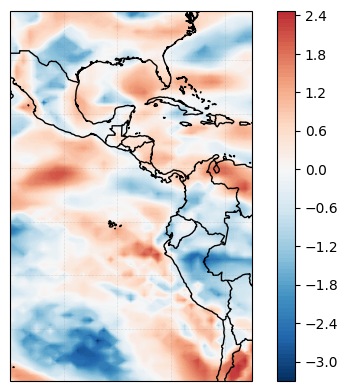

In [57]:
from cartopy import crs as ccrs, feature as cfeature

projPC = ccrs.PlateCarree()
lonTr2 = lon - 360
lonW = min(lonTr2)#180 - max(lon)
lonE = max(lonTr2)#180 - min(lon)
latS = min(lat)
latN = max(lat)
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
res = '50m'

ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(
            draw_labels=False, linewidth=0.5, color='gray', alpha=0.2, linestyle='--'
        )
ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
ax.coastlines(resolution=res, color='black')
ax.add_feature(cfeature.BORDERS);
lon2D, lat2D = np.meshgrid(np.unique(lon), np.unique(lat))
lon2Dtr = 180 - lon2D
lon2Dtr2 = lon2D - 360
datatoplot = obs[2, locsorder.argsort()].reshape(lon2Dtr2.shape)
vmax = obs[2, locsorder.argsort()].abs().max()
vmin = -vmax
        
dataplot = ax.contourf(lon2Dtr2, lat2D, datatoplot, 100,
                        transform=ccrs.PlateCarree(), cmap = 'RdBu_r', vmin = vmin, vmax = vmax,
                        )
plt.colorbar(dataplot, orientation = "vertical")


Clearly anisotropy is present in the sample. Let us now train the two transport maps in a similar way as we did before.

In [39]:
## we randomly select n=1 samples for training and the rest for testing.
n = 1     # number of training samples, change it to your desired value.
obsTrain = obs[n, :]
if obsTrain.dim() == 1:
    obsTrain = obsTrain.unsqueeze(0)
data = Data.new(torch.as_tensor(locsTrain).float(), obsTrain, torch.as_tensor(nn))

tm = SimpleTM(data, theta_init=None, linear=False, smooth=1.5, nug_mult=4.0)
opt = torch.optim.Adam(tm.parameters(), lr=0.01)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, nsteps)
res = tm.fit(
    nsteps, 0.1, test_data=tm.data, optimizer=opt, scheduler=sched, batch_size=900
)

shrink_tm = EstimableShrinkTM(data=data, linear=False, 
                    transportmap_smooth=1.5, 
                    parametric_kernel= "exponential",
                    param_nu=0.5,
                    param_ls=0.6,
                    nug_mult_bounded=False)
opt2 = torch.optim.Adam(shrink_tm.parameters(), lr=0.01)
sched2 = torch.optim.lr_scheduler.CosineAnnealingLR(opt2, nsteps)
res2 = shrink_tm.fit(
    nsteps, 0.1, test_data=shrink_tm.data, optimizer=opt2, scheduler=sched2, batch_size=900,

)

Train Loss: -1481.752, Test Loss: -1487.290: 100%|██████████| 200/200 [00:55<00:00,  3.59it/s]


Let's evaluate the map fitting.

In [41]:
testsampnum = 50
logScore_tm = 0
logScore_shrink = 0
for _j in range(0, testsampnum):
    with torch.no_grad():
        logScore_tm += tm.score((obs[(10 + _j), :]))
        logScore_shrink += shrink_tm.score((obs[(10 + _j), :]))

In [42]:
print(f"ShrinkTM log score: {logScore_shrink/testsampnum}, SimpleTM log score: {logScore_tm/testsampnum}")

ShrinkTM log score: -1177.750732421875, SimpleTM log score: -2434.3515625


Even with the log-precipitation data, where anisotropy and non-linearity is present, `ShrinkTM` still outperforms `SimpleTM`, even with $n=1$ sample. Let us visualize the results now. We perform conditionl simulation to fix the observation at first 100 locations and see how the trained transport map performs in producing samples.

In [74]:
xfix = obs[2, :100]
tm_sample = tm.cond_sample(x_fix = xfix).squeeze()
shrink_tm_sample = shrink_tm.cond_sample(x_fix = xfix).squeeze()
part_samples = [tm_sample, shrink_tm_sample]

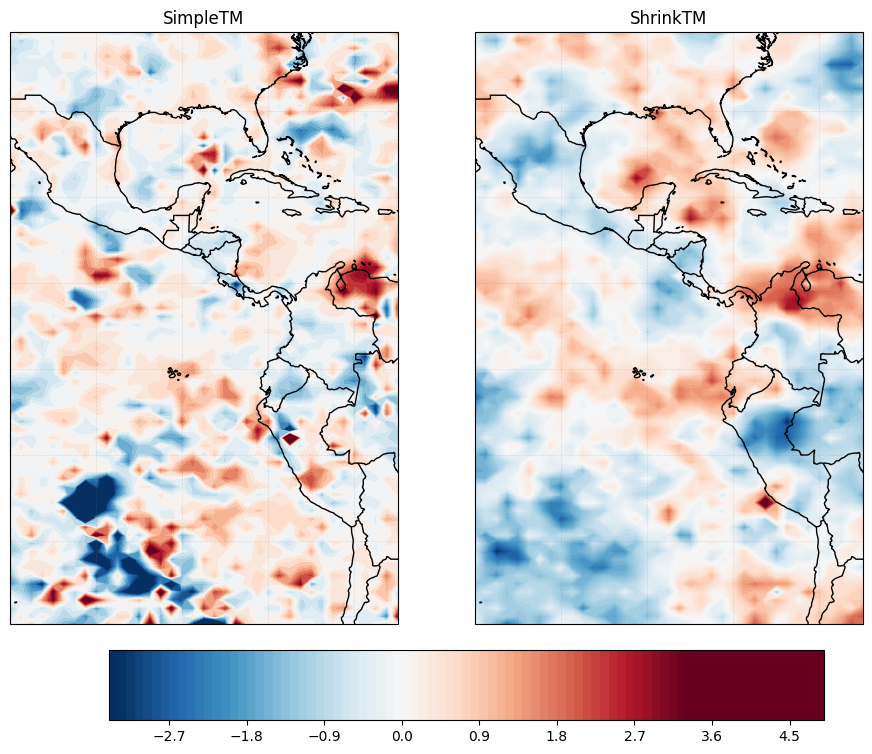

In [77]:
from cartopy import crs as ccrs, feature as cfeature

projPC = ccrs.PlateCarree()
lonTr2 = lon - 360
lonW = min(lonTr2)#180 - max(lon)
lonE = max(lonTr2)#180 - min(lon)
latS = min(lat)
latN = max(lat)
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
res = '50m'


fig, ax = plt.subplots(1, 2, figsize=(11,14),  subplot_kw={'projection': ccrs.PlateCarree()})

for i in range(0, 2):
    gl = ax[i].gridlines(
            draw_labels=False, linewidth=0.5, color='gray', alpha=0.2, linestyle='--'
        )
    ax[i].set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax[i].coastlines(resolution=res, color='black')
    ax[i].add_feature(cfeature.BORDERS);
    lon2D, lat2D = np.meshgrid(np.unique(lon), np.unique(lat))
    lon2Dtr = 180 - lon2D
    lon2Dtr2 = lon2D - 360
    datatoplot = part_samples[i][locsorder.argsort()].reshape(lon2Dtr2.shape)   
    dataplot = ax[i].contourf(lon2Dtr2, lat2D, datatoplot, 100,
                            transform=ccrs.PlateCarree(), cmap = 'RdBu_r', vmin = vmin, vmax = vmax,
                            )
    if (i == 0):
        ax[i].set_title("SimpleTM")
    else:
        ax[i].set_title("ShrinkTM")
cbar_ax = fig.add_axes(rect=[0.215, 0.215, 0.65, 0.05])
cbar_ax.set_aspect('auto')
#cbar_ax.can_zoom()
plt.colorbar(dataplot, cax = cbar_ax, shrink = 1.0, orientation = "horizontal")


Note that many long range dependences are already showing up in the conditional samples of `ShrinkTM`, which is not so clearly visible in `SimpleTM`. Furthermore, `SimpleTM` produces lot more artifacts than `ShrinkTM`. This emphasizes the efficiency of our method.